# This code will train the UNet++ (will be used as a PTM) and save weights  using a data generator

In [7]:
#import libraries and the functions we defined
import os
import numpy as np
import keras
import tensorflow 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Networks import models
from Networks.metrics import dice_coef, jaccard_distance
from sklearn.model_selection import train_test_split
import nibabel as nib
import shutil
from keras.models import load_model
from Data_Gen_2D import DataGenerator 

In [8]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[]

In [2]:
#get the dataset path, input and masks
def get_file_and_path(data_path, phrase):
    set_of = [os.path.join(data_path, f) for f in os.listdir(data_path) if phrase in f]
    return set_of

In [3]:
#define the input image and mask locations
data_path_1 = r"D:\Data_128\data\\"
#use the function to collect all input images
images_1 = get_file_and_path(data_path_1, '_M')
images = images_1
print(len(images))
#similarly gather all the masks
labels_1 = get_file_and_path(data_path_1, '_K')
labels = labels_1 
print(len(labels))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Data_128\\data\\\\'

In [4]:
#map the masks to the corresponding input images
labels = {image: i for i, image in enumerate(images)}
print(len(labels))

NameError: name 'images' is not defined

In [6]:
#backup
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

## Use the below code if you want the program to split the training, validation and test images

In [13]:
# getting the patient id list
id_list = [os.path.basename(image)[:11] for image in images]
unique_ids = list(set(id_list))
print(len(unique_ids))
# Splitting data into train and validation sets
train_ids, val_ids = train_test_split(unique_ids, train_size=0.8)

train_list = [image for image in images if any(phrase in image for phrase in train_ids)]
val_list = [image for image in images if any(phrase in image for phrase in val_ids)]
partition = {'train': train_list, 'validation': val_list}
print(len(train_ids))
print(len(val_ids))
print(len(train_list))
print(len(val_list))

360
288
72
63671
15636


## Use the below code if you have an excel file with the train, test and val ids
Make sure you have three columns in the excel file for training, validation and testing

In [7]:
labels = {image: i for i, image in enumerate(images)}
print(len(labels))
id_list = [os.path.basename(image)[:17] for image in images]
unique_ids = list(set(id_list))

79307


In [8]:
import pandas as pd

df = pd.read_excel(r"C:\Users\UAB\Segmentation - Main1_CK\Human Model\Keras\Data for AI development.xlsx", engine='openpyxl')
df = df.iloc[1:, 0:4]
df.columns = df.iloc[0]

train_csv_list = df.filter(regex='Training').iloc[:, 0].dropna().values.tolist()[1:]
val_csv_list = df.filter(regex='Validation').iloc[:, 0].dropna().values.tolist()[1:]

train_sets = [name for name in unique_ids for phrase in train_csv_list if phrase[:-2] in name and phrase[-1] in name]
val_sets = [name for name in unique_ids for phrase in val_csv_list if phrase[:-2] in name and phrase[-1] in name]

train_list = [image for image in images if any(phrase in image for phrase in train_sets)]
val_list = [image for image in images if any(phrase in image for phrase in val_sets)]


In [9]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

171
439240L
19
457036L


In [21]:
print(len(train_list))
print(len(val_list))
partition = {'train':train_list, 'validation':val_list}

70712
9042


# Set up Training Environment 

In [22]:
params = {'dim': (128,128),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
X,y = training_generator[8]
print(X.shape, y.shape)

(32, 128, 128, 1) (32, 128, 128, 2)


## Visualize if images are correctly mapped with their masks

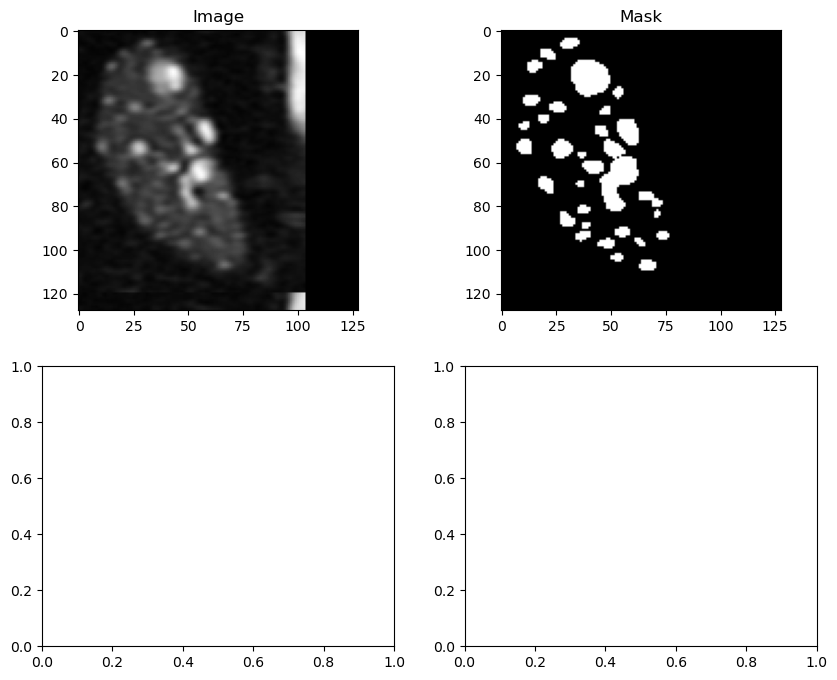

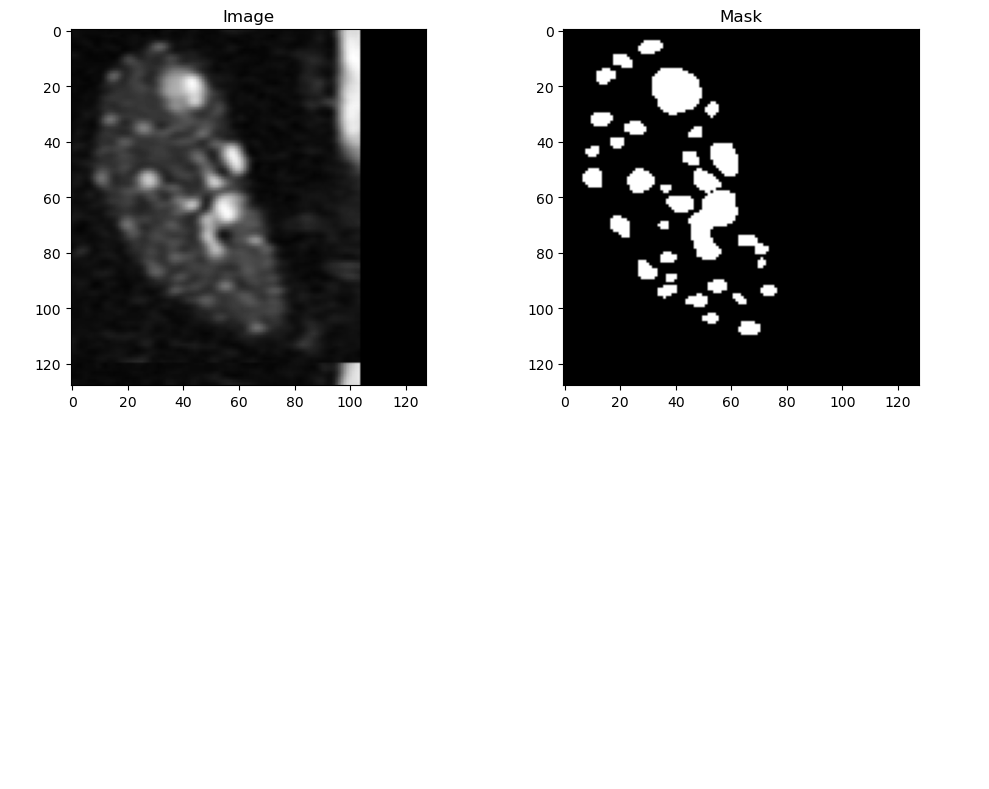

In [33]:
n = 10
X_batch = X[n,:,:,:]
X_img = X_batch[:,:,0]

y_batch = y[n,:,:,:]
y_img_1 = y_batch[:,:,1]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(X_img, cmap='gray')
axs[0, 0].set_title('Image')

axs[0, 1].imshow(y_img_1, cmap='gray')
axs[0, 1].set_title('Mask')

axs[1, 0].axis('off')  # Hide the empty subplot
axs[1, 1].axis('off')  # Hide the empty subplot

plt.tight_layout()
plt.show()

In [3]:
model = models.unetpp_2d((None, None, 1), [64, 128, 256, 512, 1024], n_labels=2,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      apply_batch_norm=True, pool='max', unpool='nearest', name='unetpp')

model.summary()

Model: "unetpp_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 unetpp_down0_0 (Conv2D)        (None, None, None,   576         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 unetpp_down0_0_bn (BatchNormal  (None, None, None,   256        ['unetpp_down0_0[0][0]']         
 ization)                       64)                                                    

                                                                                                  
 unetpp_down3_conv_1_activation  (None, None, None,   0          ['unetpp_down3_conv_1_bn[0][0]'] 
  (GELU)                        512)                                                              
                                                                                                  
 unetpp_down4_encode_maxpool (M  (None, None, None,   0          ['unetpp_down3_conv_1_activation[
 axPooling2D)                   512)                             0][0]']                          
                                                                                                  
 unetpp_down4_conv_0 (Conv2D)   (None, None, None,   4718592     ['unetpp_down4_encode_maxpool[0][
                                1024)                            0]']                             
                                                                                                  
 unetpp_do

 unetpp_up2_conv_before_concat_  (None, None, None,   512        ['unetpp_up2_conv_before_concat_0
 0_bn (BatchNormalization)      128)                             [0][0]']                         
                                                                                                  
 unetpp_up2_conv_before_concat_  (None, None, None,   0          ['unetpp_up2_conv_before_concat_0
 0_activation (GELU)            128)                             _bn[0][0]']                      
                                                                                                  
 unetpp_up2_concat (Concatenate  (None, None, None,   0          ['unetpp_up2_conv_before_concat_0
 )                              256)                             _activation[0][0]',              
                                                                  'unetpp_down1_conv_1_activation[
                                                                 0][0]']                          
          

In [39]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Define the patience values for each monitored quantity
patience_loss = 5
patience_val_loss = 5

# Set the file path for saving the best model based on training loss
filepath_loss = "UNet+_cys_train.h5"

# Set the file path for saving the best model based on validation loss
filepath_val_loss = "UNet+_cys_val.h5"

# Define the ModelCheckpoint callbacks for each monitored quantity
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Define the EarlyStopping callbacks for each monitored quantity
early_stopping_loss = EarlyStopping(monitor='loss', patience=patience_loss)
early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=patience_val_loss)

# Create a list of callbacks for each monitored quantity
callbacks_list_loss = [checkpoint_loss, early_stopping_loss]
callbacks_list_val_loss = [checkpoint_val_loss, early_stopping_val_loss]

# Create a TimingCallback to measure the training time
cb = TimingCallback()
callbacks_list = callbacks_list_loss+callbacks_list_val_loss

In [40]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [41]:
# Train model on dataset
history = model.fit(training_generator, epochs = 200,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[callbacks_list])

Epoch 1/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0334 - dice_coef: 0.9830
Epoch 1: loss improved from inf to 0.03344, saving model to sUNet_cys_train.h5

Epoch 1: val_loss improved from inf to 0.04128, saving model to sUNet_cys_val.h5
4419/4419 [==============================] - 3432s 773ms/step - loss: 0.0334 - dice_coef: 0.9830 - val_loss: 0.0413 - val_dice_coef: 0.9790
Epoch 2/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0242 - dice_coef: 0.9877
Epoch 2: loss improved from 0.03344 to 0.02421, saving model to sUNet_cys_train.h5

Epoch 2: val_loss improved from 0.04128 to 0.03182, saving model to sUNet_cys_val.h5
4419/4419 [==============================] - 706s 160ms/step - loss: 0.0242 - dice_coef: 0.9877 - val_loss: 0.0318 - val_dice_coef: 0.9838
Epoch 3/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0227 - dice_coef: 0.9884
Epoch 3: loss improved from 0.02421 to 0.02274, saving model to sUNet_cys_train.h5

Epoch 3

Epoch 22/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0150 - dice_coef: 0.9924
Epoch 22: loss improved from 0.01524 to 0.01496, saving model to sUNet_cys_train.h5

Epoch 22: val_loss did not improve from 0.02533
4419/4419 [==============================] - 706s 160ms/step - loss: 0.0150 - dice_coef: 0.9924 - val_loss: 0.0263 - val_dice_coef: 0.9866
Epoch 23/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0147 - dice_coef: 0.9925
Epoch 23: loss improved from 0.01496 to 0.01473, saving model to sUNet_cys_train.h5

Epoch 23: val_loss did not improve from 0.02533
4419/4419 [==============================] - 705s 159ms/step - loss: 0.0147 - dice_coef: 0.9925 - val_loss: 0.0308 - val_dice_coef: 0.9843
Epoch 24/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0146 - dice_coef: 0.9926
Epoch 24: loss improved from 0.01473 to 0.01456, saving model to sUNet_cys_train.h5

Epoch 24: val_loss did not improve from 0.02533
4419/4419 [=========

In [44]:
#epoch_times = history.history['epoch_times']
val_losses = history.history['val_loss']
train_losses = history.history['loss']
val_dice = history.history['val_dice_coef']  # Replace with the actual key for validation dice score
train_dice = history.history['dice_coef']  # Replace with the actual key for training dice score

In [45]:
import pandas as pd
data = pd.DataFrame({
    'Epoch': range(1, len(val_losses) + 1),
    'Val Loss': val_losses,
    'Train Loss': train_losses,
    'Val Dice': val_dice,
    'Train Dice': train_dice
})

# Export the DataFrame to an Excel file
data.to_excel(r"D:\Results_CK\UNet++\Cyst\train.xlsx", index=False)

# Prediction 

In [3]:
#get the images
def gather_images(data_path):
    images = [f for f in os.listdir(data_path) if '_M' in f]
    return images

In [4]:
#define custom objects
def Hausdorff_distance(y_true, y_pred, smooth=100):
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(self, y_true, y_pred):
    loss = 1 - self._dice_coef(y_true, y_pred)
    return loss

In [11]:
#load weights
model = models.unetpp_2d((None, None, 1), [64, 128, 256, 512, 1024], n_labels=2,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      apply_batch_norm=True, pool='max', unpool='nearest', name='unetpp')
model.load_weights(r"C:\Users\UAB\Downloads\ML-Model-Compression-Techniques\saved\unet++_cys_v1.h5")

'''

    model = keras.models.load_model("unet++_cys_best_train.h5", custom_objects={
                           'jaccard_distance': jaccard_distance,
                           'dice_coef_loss': dice_coef_loss,
                           'dice_coef': dice_coef}) #load the weights
'''
model_name = 'test'  #give a name of your choice
data_path = r"D:\Data_128\data\\"  #set the path to masks and imgaes
images = gather_images(data_path) #get the input images using the defined functions
print(len(images))  #check if the images are gathered correctly
print(images[2000])
print(images[0:2])

79307
110080_2_87_L_82_M.npy
['101934_0_96_L_0_M.npy', '101934_0_96_L_10_M.npy']


In [12]:
image_list = []
phrase_list1 = ['283935R','290336L','290336R','295106L','295106R']
phrase_list2 = ['380166R','383193L','383193R','385151L','385151R']
phrase_list3 = ['457036L','457036R']
phrase_list4 = ['113994L','139486R','157925R','183417R','186714L','186714R','187456L']
phrase_list = phrase_list3+phrase_list2+phrase_list1+phrase_list4
for phrase in phrase_list: #gather all the images corresponding to test phrases
    image_list.extend([name for name in images if phrase[:-2] in name and phrase[-1] in name])

label_mapping = {name: index for index, name in enumerate(images)} #map the labels for prediction
labels = {name: label_mapping[name] for name in image_list}

In [13]:
#the below code does the prediction by passing the test images 
import numpy
import nibabel


label_list = []
predictions = []
pred_path1 = r"D:\npy" #set the location to save the predicted arrays
#pred_path2 = r"D:\NII" #optional - if u want to convert npy to nii
images = image_list

for i, image in enumerate(images):
    image_stack = np.empty((1, 128, 128, 1))  # create a tensor to hold images
    image = np.load(os.path.join(data_path, image))
    image_stack[0, ..., 0] = image  #assign the image as a part of stack
    label_match = str(images[i][:-5] + 'C.npy') #match label
    label_list.append(label_match)

    img_prediction = model.predict(image_stack)  #model prediction

    for z, img_pred in enumerate(img_prediction): #saving the prediction as nii or npy
        img_numb = z + i
        image_save = img_pred[:, :]  #removing extra axis from the predicted image
        label = label_list[img_numb][:-5]
        filename = f"{label}{model_name}_P.npy"
        filename1 = f"{label}{model_name}_P.nii"
        np.save(os.path.join(pred_path1, filename), image_save)
        #the below code is optional if the above npy have to be saved as nii
        #image = np.load(os.path.join(pred_path1, filename))
        #affine = numpy.eye(4)
        #nifti_file = nibabel.Nifti1Image(image_save, affine)
        #nib.save(nifti_file, os.path.join(pred_path2, filename1))